# calculate the reference values for the 4 outputs

In [1]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json
import matplotlib
import copy
import pingouin as pg

from scipy.stats import pearsonr


/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
file_fpath = 'all_biomarkers_correct3.csv'
df=pd.read_csv(file_fpath)

In [3]:
mode = 'valid'  # valid or test
net_pred_fpath0 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2750/{mode}_pred.csv"
df_net_pred = pd.read_csv(net_pred_fpath0)

net_label_fpath = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2663/{mode}_label.csv"
df_net_label = pd.read_csv(net_label_fpath)

# net_pred_fpath1 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2663/{mode}_pred.csv"
# net_pred_fpath2 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2654/{mode}_pred.csv"
# net_pred_fpath3 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2655/{mode}_pred.csv"
# net_pred_fpath4 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2661/{mode}_pred.csv"


# df_net_pred1 = pd.read_csv(net_pred_fpath1)
# df_net_pred2 = pd.read_csv(net_pred_fpath2)
# df_net_pred3 = pd.read_csv(net_pred_fpath3)
# df_net_pred4 = pd.read_csv(net_pred_fpath4)
# df_net_pred = pd.DataFrame({'pat_id': df_net_pred1['pat_id'],'DLCOc':df_net_pred1['DLCOc_SB'], 'FEV1': df_net_pred2['FEV1'], 'FVC': df_net_pred3['FVC'],'TLC': df_net_pred4['TLC_He'] })


In [ ]:
df_net_label

In [4]:
# extract testing dataset form the whole dataset
first_ts_pat_id = 7957098
if mode=='test':
    df_label = df.loc[df['PatID'] >= first_ts_pat_id]
else:
    df_label = df.loc[df['PatID'] < first_ts_pat_id]
df_label = df_label.rename(columns={'PatID':'pat_id'})

In [5]:
# remove one patient without the % predicted values because of the insuffient technique
pat_id_wo_pred = 8334199
pat_id_wo_pred2 = 315457
pat_id_wo_pred_ls = [8334199, 315457, 4036570]
pat_id_otherrror_ls = [422335]  # exclude '422335' which has bad image quality

pat_id_rm_ls = pat_id_wo_pred_ls + pat_id_otherrror_ls

for i in pat_id_rm_ls:
    print(i)
    df_net_pred = df_net_pred[df_net_pred['pat_id']!=i]
    df_net_label = df_net_label[df_net_label['pat_id']!=i]
    df_label = df_label[df_label['pat_id']!=i]


8334199
315457
4036570
422335


In [6]:
df_net_pred = df_net_pred.rename(columns={'DLCOc_SB':'DLCOc', 'TLC_He': 'TLC'})
df_net_label = df_net_label.rename(columns={'DLCOc_SB':'DLCOc', 'TLC_He': 'TLC'})

df_label = df_label.sort_values('pat_id').set_axis(range(len(df_label)))
df_net_pred = df_net_pred.sort_values('pat_id').set_axis(range(len(df_net_pred)))
df_net_label = df_net_label.sort_values('pat_id').set_axis(range(len(df_net_label)))
df_net_pred.columns

Index(['pat_id', 'DLCOc', 'FEV1', 'FVC', 'TLC'], dtype='object')

In [73]:
# 设置显示选项以避免省略 DataFrame 的元素
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.expand_frame_repr', False)  # 当行太长时不换行显示


In [7]:
len(df_label)

251

In [8]:
for i in zip(df_label['pat_id'], df_label['DLCOc'], df_net_label['DLCOc'], df_net_pred['DLCOc']):
    print(i)

(68800, 7.102, 7.102, 7.13)
(127512, 3.943, 3.943, 3.105)
(139552, 5.273, 5.273, 4.855)
(143788, 1.24, 1.24, 3.379)
(152440, 7.102, 7.102, 5.18)
(163750, 6.444, 6.444, 3.959)
(213786, 1.995, 1.995, 3.553)
(219312, 11.284, 11.284, 9.95)
(222357, 3.034, 3.034, 3.656)
(234084, 3.799, 3.799, 4.812)
(242508, 4.965, 4.965, 5.96)
(265042, 7.525, 7.525, 6.773)
(277377, 7.439, 7.439, 6.844)
(280727, 6.568, 6.568, 8.67)
(298877, 5.406, 5.406, 5.316)
(315573, 6.55, 6.55, 7.3)
(320142, 4.248, 4.248, 4.44)
(343115, 4.079, 4.079, 4.805)
(376540, 3.07, 3.07, 4.473)
(385738, 7.528, 7.528, 4.74)
(456204, 2.911, 2.911, 2.332)
(458234, 7.183, 7.183, 9.01)
(485784, 5.92, 5.92, 5.984)
(509944, 6.57, 6.57, 6.23)
(530988, 6.733, 6.733, 5.816)
(534778, 4.902, 4.902, 6.96)
(553478, 4.336, 4.336, 4.81)
(573200, 9.153, 9.153, 7.86)
(584534, 4.618, 4.618, 6.477)
(611832, 3.861, 3.861, 2.604)
(639432, 2.223, 2.223, 3.488)
(703966, 7.21, 7.21, 6.426)
(787506, 5.994, 5.994, 6.816)
(911478, 7.427, 7.427, 7.99)
(99275

In [9]:
# icc
def icc(label, pred, columns = []):
    label['ID'] = np.arange(1, len(label) + 1)
    label['rater'] = 'label'

    pred['ID'] = np.arange(1, len(pred) + 1)
    pred['rater'] = 'pred'

    data = pd.concat([label, pred], axis=0)

    for column in columns:
        icc = pg.intraclass_corr(data=data, targets='ID', raters='rater', ratings=column).round(2)
        icc = icc.set_index("Type")
        icc = icc.loc['ICC2']['ICC']
        print(f"icc for {column}: {icc}")
    return icc
        # prefix = label_fpath.split("/")[-1].split("_")[0]
        # icc_dict['icc_' + prefix + '_' + column] = icc

In [10]:
icc_value = icc(df_label, df_net_pred,columns=['DLCOc', 'FEV1', 'FVC', 'TLC'])  #['DLCOc', 'FEV1', 'FVC', 'TLC']


icc for DLCOc: 0.7
icc for FEV1: 0.76
icc for FVC: 0.8
icc for TLC: 0.81


In [11]:
for column in ['DLCOc', 'FEV1', 'FVC', 'TLC']:
    df_net_pred[column+'PP'] = df_net_pred[column] / (df_label[column+"Ref"]) * 100


In [12]:
df_label_slim = df_label[['pat_id','rater','DLCOc', 'FEV1', 'FVC', 'TLC','DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP' ]]

In [13]:
# remove one patient without the % predicted values because of the insuffient technique
pat_id_wo_pred = [456204]

for i in pat_id_wo_pred:
    print(i)
    df_net_pred = df_net_pred[df_net_pred['pat_id']!=i]
    df_net_label = df_net_label[df_net_label['pat_id']!=i]
    df_label_slim = df_label_slim[df_label_slim['pat_id']!=i]


456204


In [14]:
len(df_label_slim)

250

In [15]:
icc_value1 = icc(df_label_slim, df_net_pred,columns=['DLCOc', 'FEV1', 'FVC', 'TLC'])  #['DLCOc', 'FEV1', 'FVC', 'TLC']

icc_value2 = icc(df_label_slim, df_net_pred,columns=['DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])


icc for DLCOc: 0.7
icc for FEV1: 0.75
icc for FVC: 0.8
icc for TLC: 0.81
icc for DLCOcPP: 0.6
icc for FEV1PP: 0.6
icc for FVCPP: 0.69
icc for TLCPP: 0.75


In [ ]:
plt.figure()


In [16]:
# show the r between net output and pft values
for colname in ['DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']:
    corr, p_value = pearsonr(df_net_pred[colname], df_label_slim[colname])
    mean = (df_net_pred[colname] - df_label_slim[colname]).mean()
    std = (df_net_pred[colname] - df_label_slim[colname]).std()
    MAE = (df_net_pred[colname] - df_label_slim[colname]).abs().mean()
    std_mae = (df_net_pred[colname] - df_label_slim[colname]).abs().std()

    print(f"{colname}:\t r: {corr:.3f}, mean: {mean:.2f}, std, {std:.2f}, MAE, {MAE:.2f}, std_mae: {std_mae:.2f}")
    


DLCOc:	 r: 0.707, mean: 0.14, std, 1.35, MAE, 1.05
FEV1:	 r: 0.769, mean: 0.15, std, 0.53, MAE, 0.42
FVC:	 r: 0.823, mean: 0.20, std, 0.61, MAE, 0.49
TLC:	 r: 0.814, mean: -0.05, std, 0.79, MAE, 0.63
DLCOcPP:	 r: 0.600, mean: 2.35, std, 17.67, MAE, 13.85
FEV1PP:	 r: 0.651, mean: 6.10, std, 18.49, MAE, 14.79
FVCPP:	 r: 0.736, mean: 5.71, std, 16.90, MAE, 13.76
TLCPP:	 r: 0.761, mean: -0.87, std, 13.65, MAE, 11.04


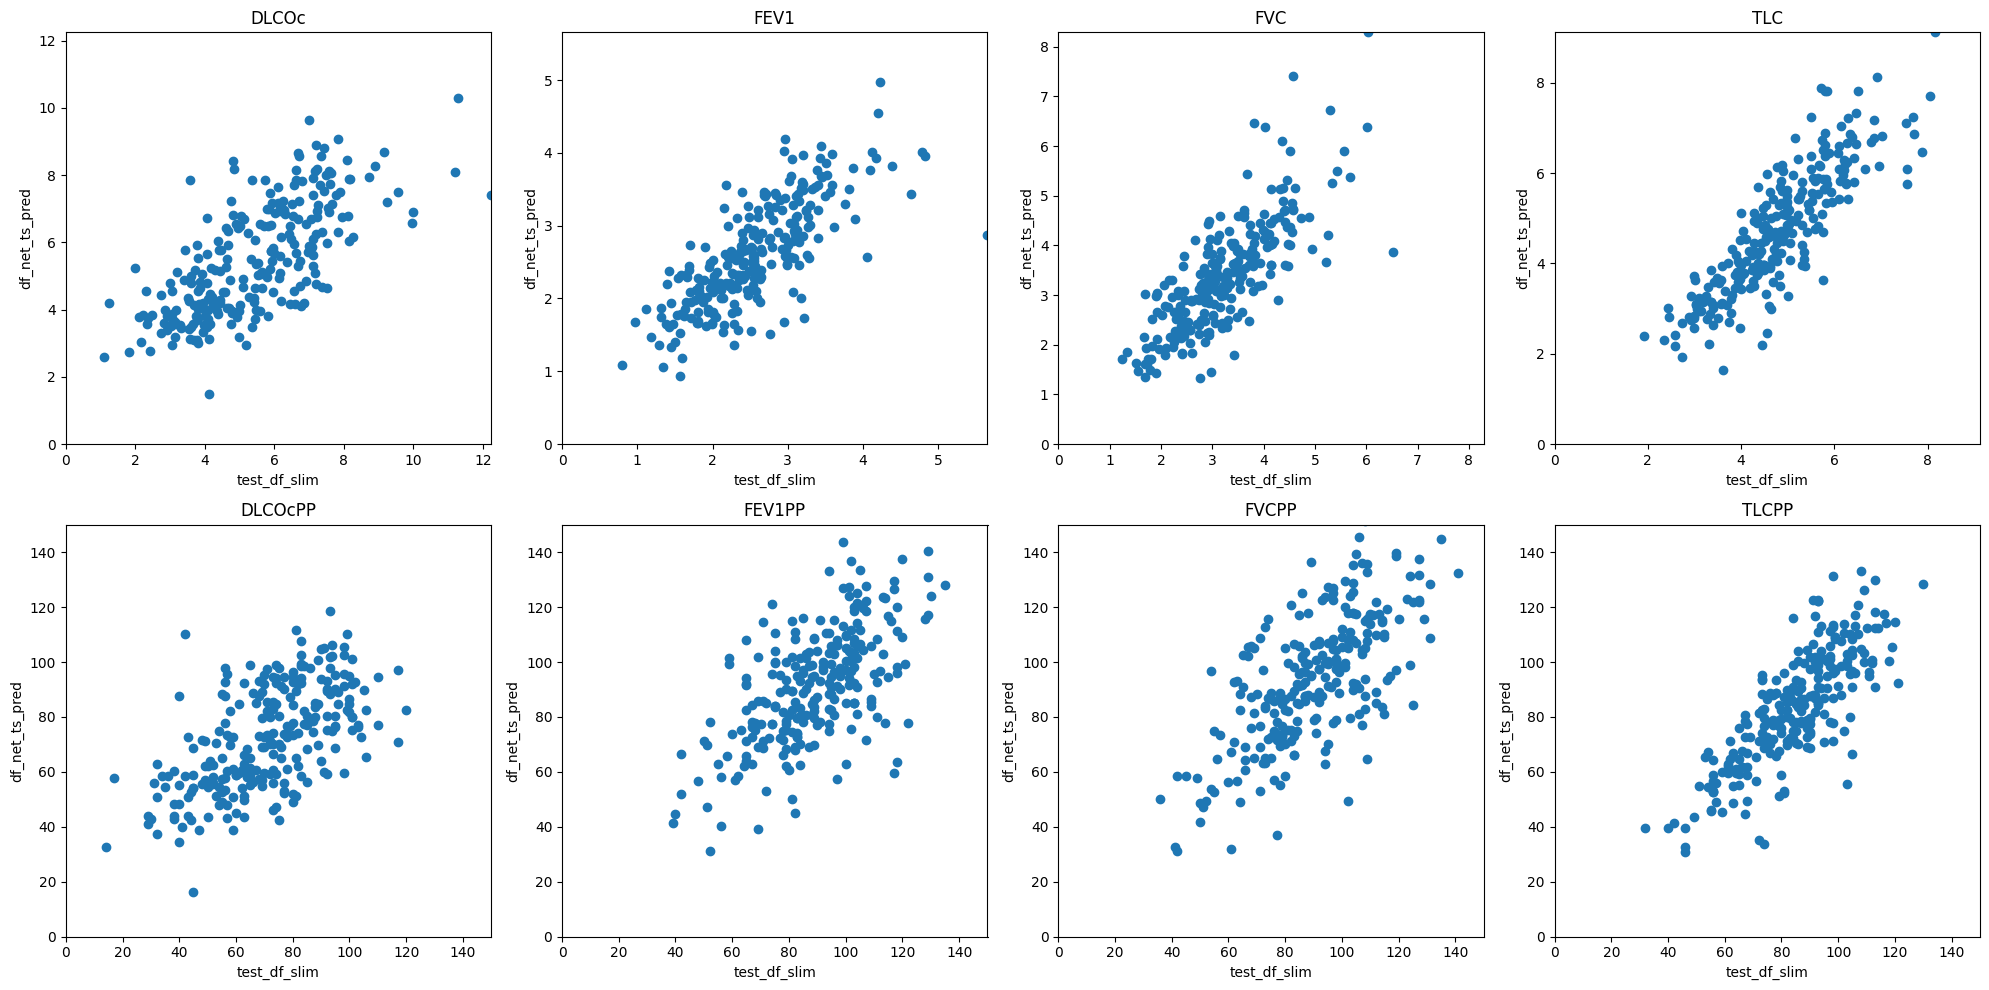

In [35]:
import matplotlib.pyplot as plt

# 列名列表
cols = ['DLCOc', 'FEV1', 'FVC', 'TLC','DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']

# 创建一个 2 行 4 列的子图
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# 循环遍历每个列
for i, name in enumerate(cols):
    # 计算子图的行和列
    row = i // 4
    col = i % 4
    
    # 绘制散点图
    axs[row, col].scatter(df_label_slim[name], df_net_pred[name])
    
    # 设置子图标题和坐标轴标签
    axs[row, col].set_title(name)
    axs[row, col].set_xlabel('test_df_slim')
    axs[row, col].set_ylabel('df_net_ts_pred')
    
    if row!=1:
        max_value = max(df_label_slim[name].max(), df_net_pred[name].max())
        axs[row, col].set_ylim(0, max_value)
        axs[row, col].set_xlim(0, max_value)
    else:
        axs[row, col].set_ylim(0, 150)
        axs[row, col].set_xlim(0, 150)
    
# 调整子图之间的间距和边距
plt.tight_layout()

# 显示图像
plt.show()


In [159]:
df_net_ts_pred['FEV1'] / test_df_slim['FEV1PP']*100

0     2.146552
1     2.498182
2     2.644898
3     3.608081
4     2.886813
        ...   
57    4.137805
58    3.622549
59    3.414000
60    2.160606
61    2.306061
Length: 62, dtype: float64

In [198]:
MAPE_FEV1 = ((df_net_ts_pred['FEV1'] - test_df_slim['FEV1']).abs()/test_df_slim['FEV1']).sum()

In [175]:
(df_net_ts_pred['FEV1'] - test_df_slim['FEV1']).abs()

0     1.145
1     0.062
2     0.149
3     0.694
4     0.002
      ...  
57    0.099
58    0.029
59    0.456
60    0.082
61    0.643
Name: FEV1, Length: 62, dtype: float64

In [176]:
test_df_slim['FEV1']

0     3.635
1     2.810
2     2.741
3     2.878
4     2.629
      ...  
57    3.492
58    3.666
59    3.870
60    2.057
61    1.640
Name: FEV1, Length: 62, dtype: float64

In [199]:
MAPE_FEV1PP = ((df_net_ts_pred['FEV1PP'] - test_df_slim['FEV1PP']).abs()/test_df_slim['FEV1PP']).sum()